# This notebook takes fits files and plots them to a healpy map

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.io import fits
from glob import glob
from astropy import wcs
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u

#%matplotlib notebook

In [2]:
path = '/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2/2458098'
nights = sorted(glob('/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2/2*')) # list of 
fitsfiles = sorted(glob(nights[17] + '/*/*image.image.fits'))
dmuellermodel = 'simfits/MuellerMatrixBeam00_150MHz.fits'
fnight, lnight = fitsfiles[0],fitsfiles[-1]
fhdu = fits.open(fnight)
lhdu = fits.open(lnight)
fheader = fhdu[0].header
lheader = lhdu[0].header


[ 0.79425851  0.32325692 -0.51444959]
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/lustre/aoc/projects/hera/gtucker/anaconda3/envs/hera/lib/python3.6/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/lustre/aoc/projects/hera/gtucker/anaconda3/envs/hera/lib/python3.6/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


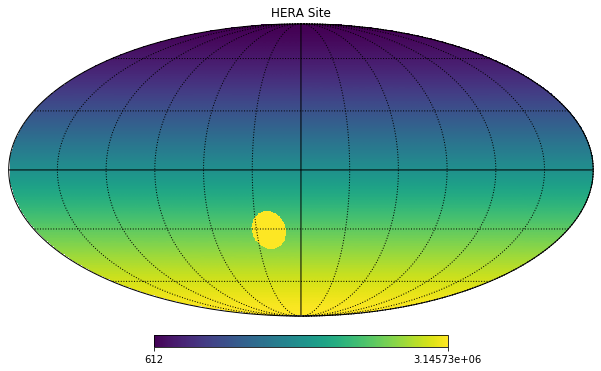

In [3]:
NSIDE = 512
NPIX = hp.nside2npix(NSIDE) #Number of pixels in image

#from google maps for HERA site
glong = 22.145934
glat = -30.960672

vec = hp.ang2vec(glong,glat,lonlat=True )
print(vec)
ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(10))

m = np.arange(NPIX)
m[ipix_disc] = m.max()
hp.mollview(m, title="HERA Site")
hp.graticule()

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


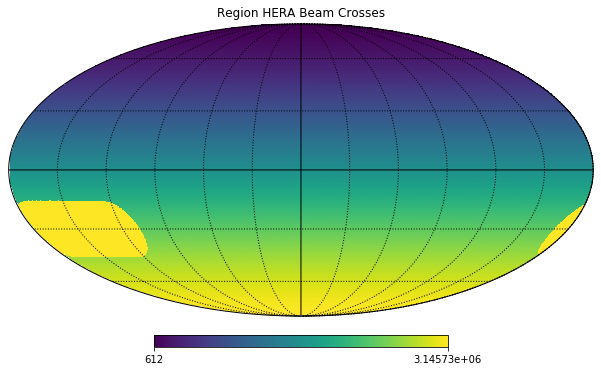

In [4]:
#Function that plots image.fits coverage in healpy,
def plot_sphere(images):
    """takes a list of images"""
    NSIDE = 512
    #Defines the amount of pixels in amge
    NPIX = hp.nside2npix(NSIDE)
    fm = np.arange(NPIX)
    for image in images:
        hdu = fits.open(image)
        header = hdu[0].header
        ra = header['OBSRA']
        dec = header['OBSDEC']
        vec = hp.ang2vec(ra, dec,lonlat=True ) #lonlat set to true because ra and dec are in degrees
        ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(15)) #region with radius of 20 deg
        fm[ipix_disc] = fm.max()
    hp.mollview(fm, title="Region HERA Beam Crosses")
    hp.graticule()

plot_sphere(fitsfiles)

Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


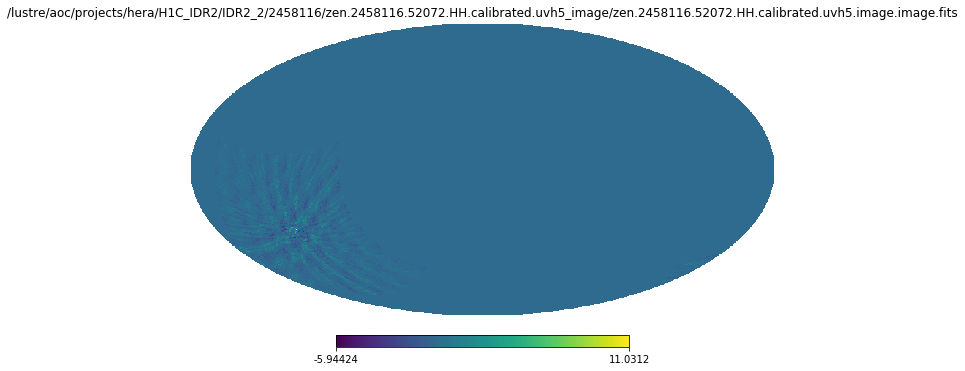

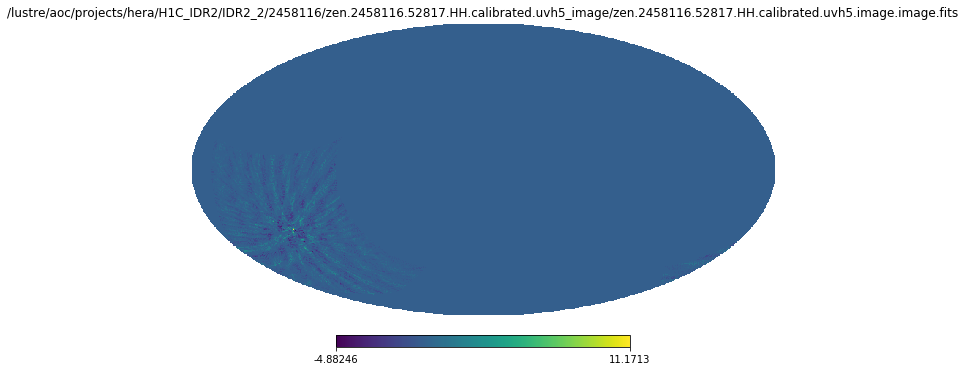

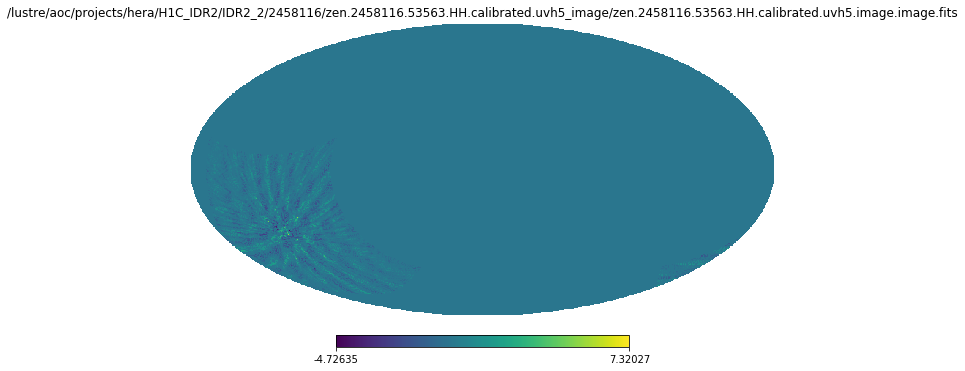

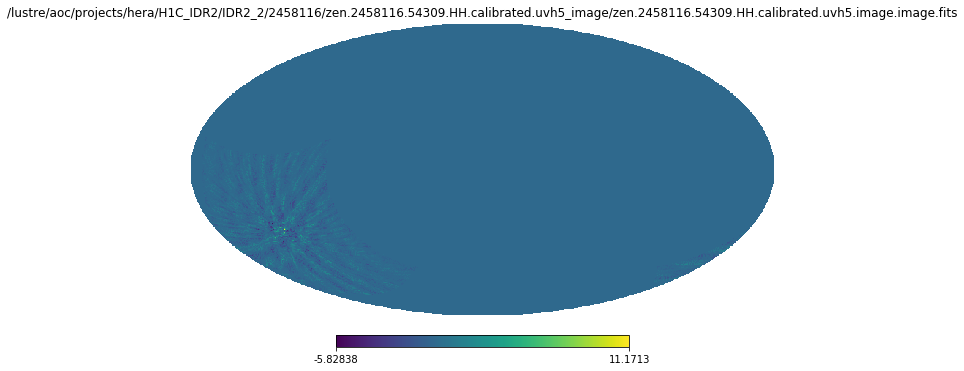

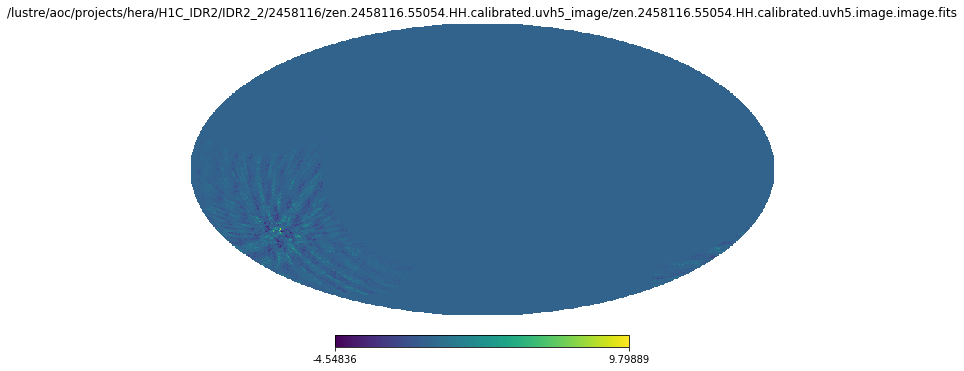

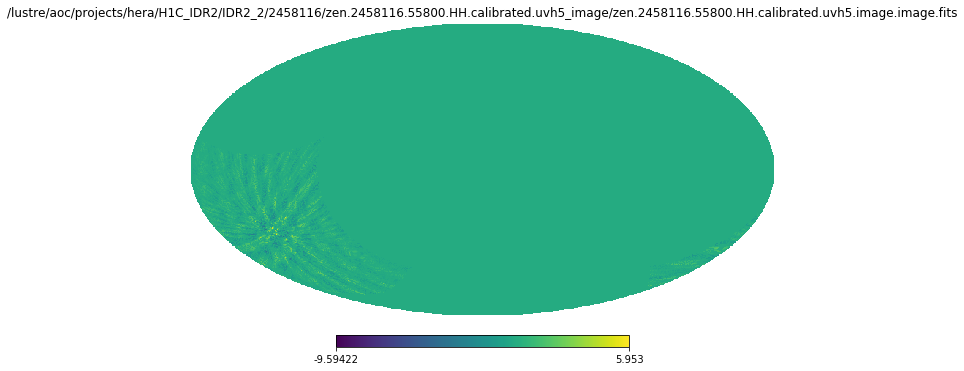

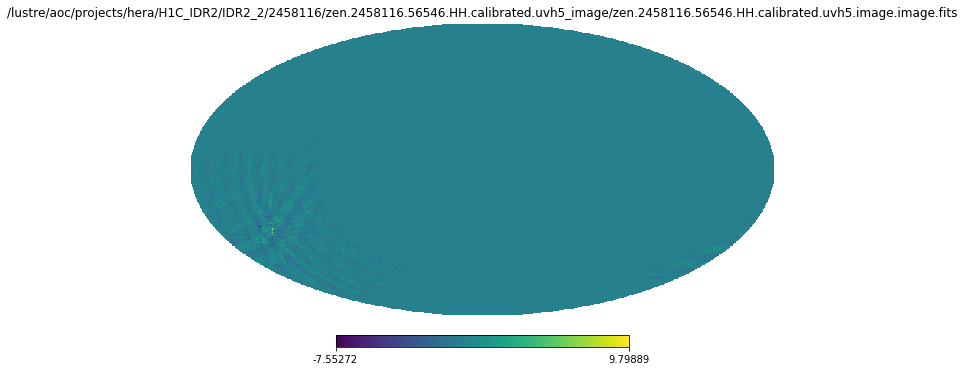

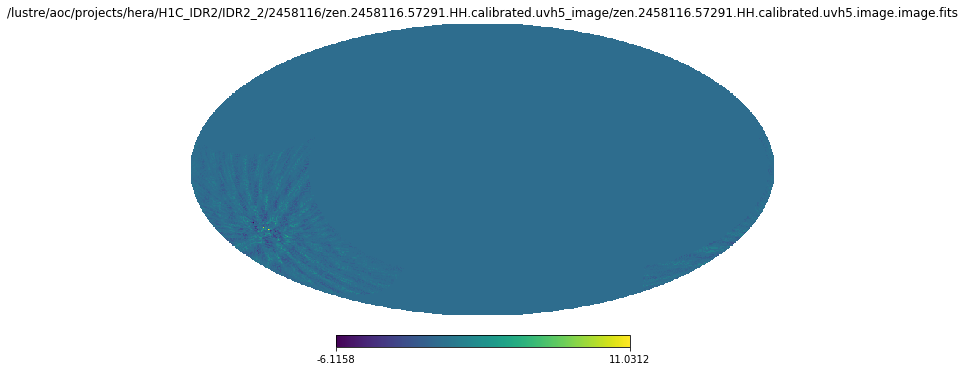

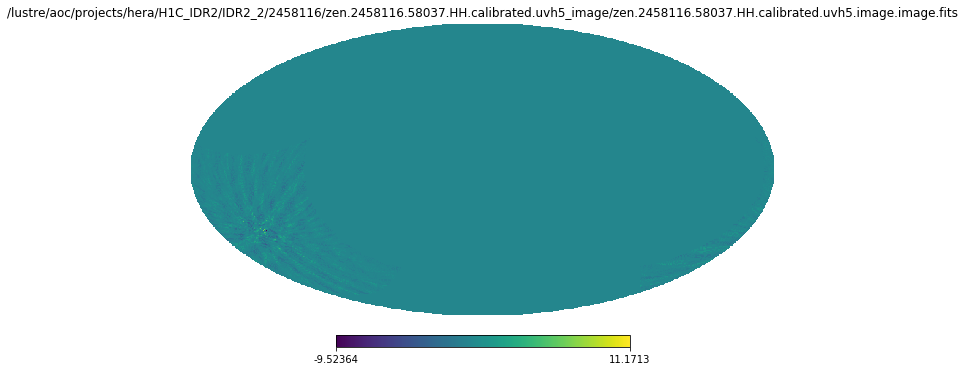

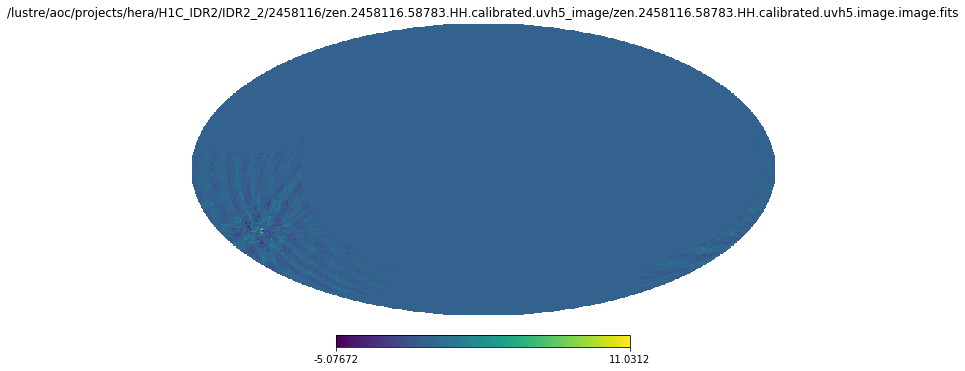

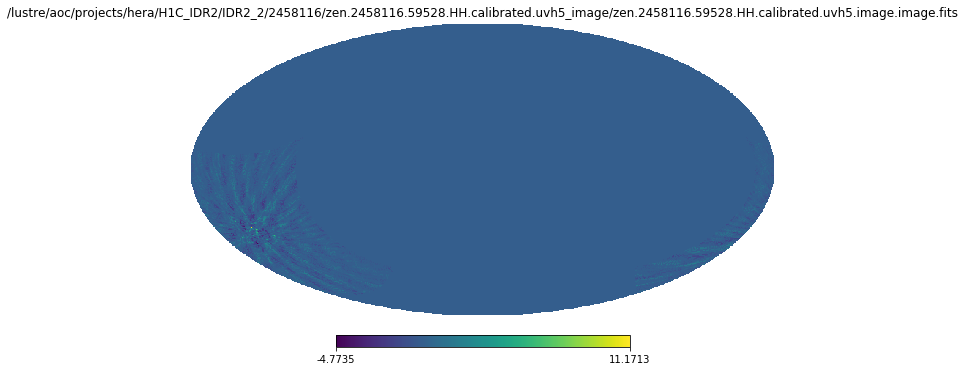

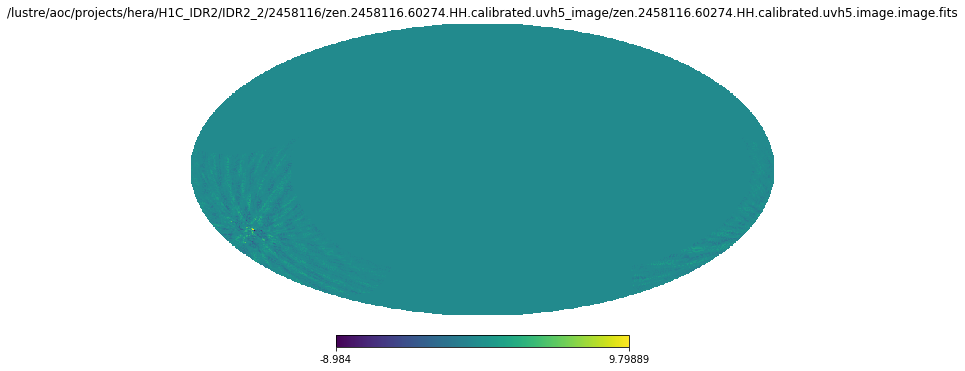

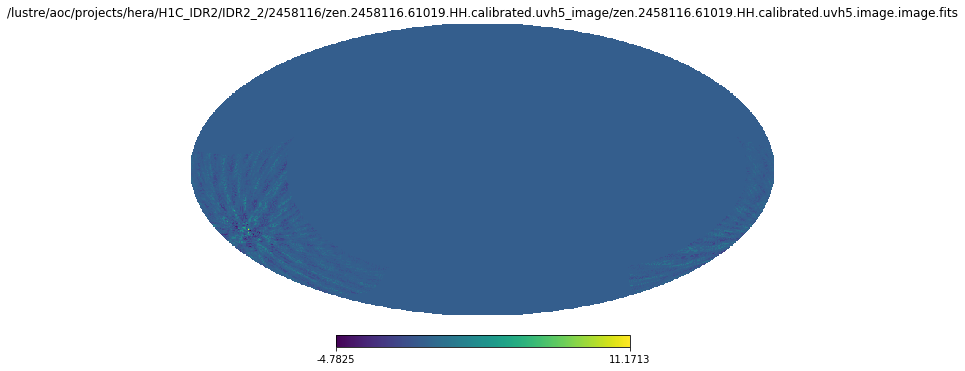

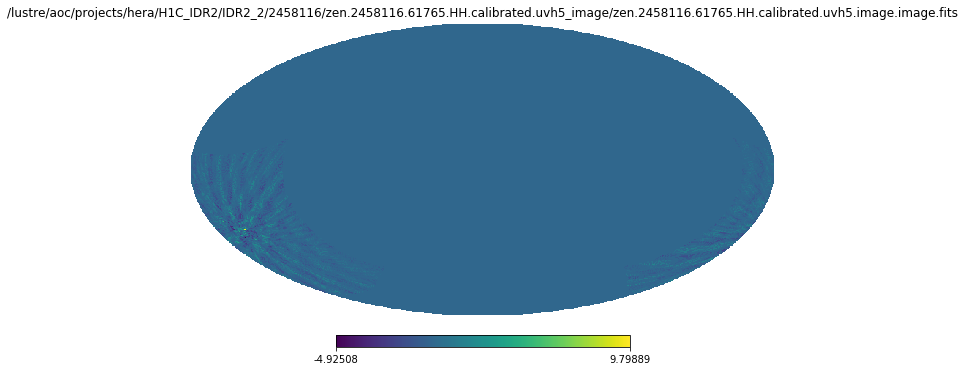

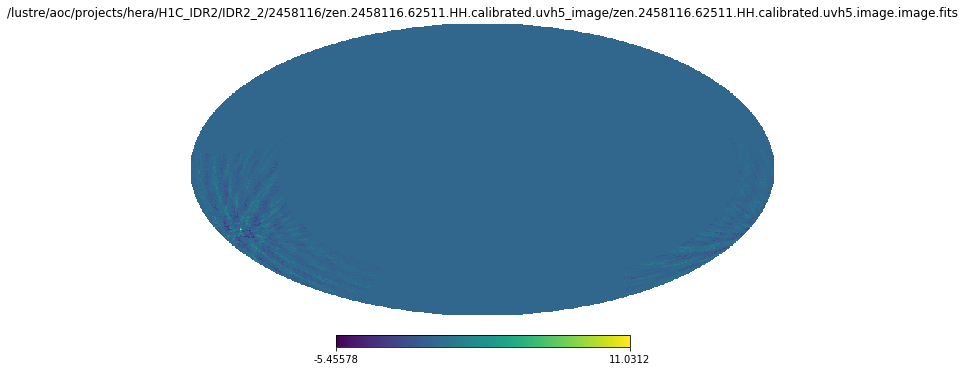

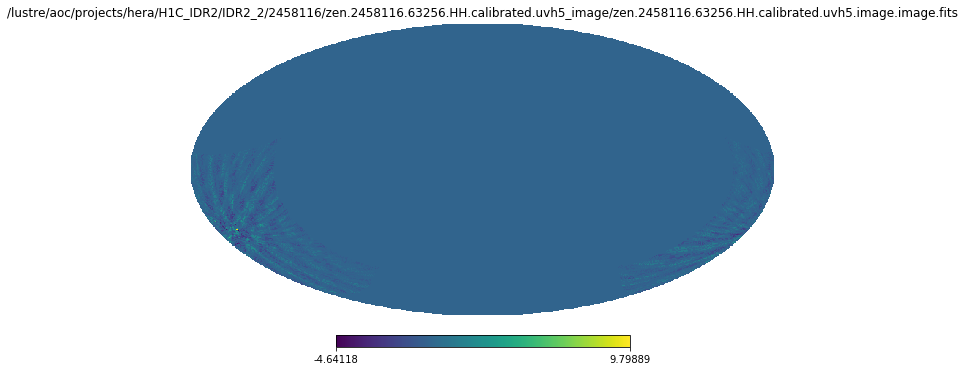

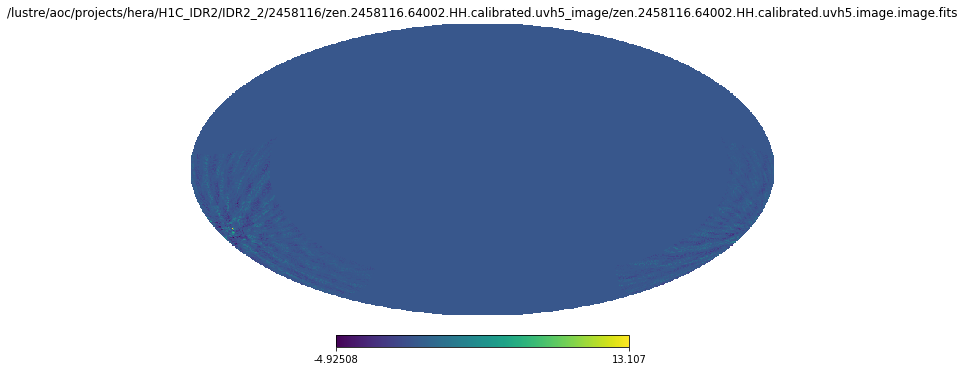

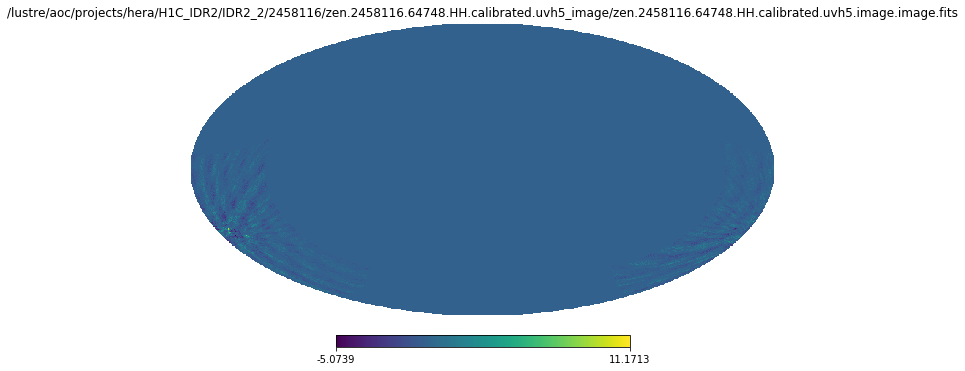

In [5]:
#function that plots image.fits into healpy
def plotter(images):
    for image in images:
        hdu = fits.open(image)
        header = hdu[0].header
        w = wcs.WCS(header)

        npix_sq = 512

        # Convert Equitorial Coordinates to Spherical Coordinates grid
        xpix, ypix = np.meshgrid(np.arange(npix_sq),np.arange(npix_sq), indexing='xy')#np.meshgrid(np.arange(1,npix+1),np.arange(1,npix+1), indexing='xy')
        ra, dec, dummy_freq, dummy_stokes = w.all_pix2world(xpix, ypix,1,1,1) #Right ascension and declination as seen on the inside of the celestial sphere
        c_icrs = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs') # Coordinates Object

        # Set the coordinates for the input
        nside = 512
        npix = hp.nside2npix(nside)

        # Coordinates and the density field f
        thetas = ra
        phis = dec
        fs = fhdu[0].data[0][0]

        # Go from HEALPix coordinates to indices
        indices = hp.ang2pix(nside, thetas, phis,lonlat=True)

        # Initate the map and fill it with the values
        hpxmap = np.zeros(npix, dtype=np.float)
        for i in range(len(fs)):
            hpxmap[indices[i]] += fs[i]
            
        # Inspect the map
        hp.mollview(hpxmap,title=image)
plotter(fitsfiles)